In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

# membuat fungsi untuk menampilkan plot dari metrik pelatihan dan validasi selama proses pelatihan model
def plot_graphs(history, metric):
  plt.plot(history.history[metric]) # Plot metrik pelatihan
  plt.plot(history.history['val_'+metric], '') # Plot metrik validasi garis putus-putus

  # Menentukan label seumbu
  plt.xlabel("Epochs")
  plt.ylabel(metric)

  # Menambahkan legenda ke plot 
  plt.legend([metric, 'val_'+metric])

In [3]:
# Memuat dataset
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test'] # Membagi data menjadi data latih dan data uji

train_dataset.element_spec 

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()) # Mencetak nilai tensor teks dari example
  print('label: ', label.numpy()) # Mencetak nilai label dari example

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mengacak dan mengelompokkan dataset pelatihan
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mengelompokkan dataset pengujian

# Mengambil satu batch dari dataset pelatihan
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3]) # Mencetak tiga nilai tensor teks dari contoh pada batch pertama
  print()
  print('labels: ', label.numpy()[:3]) # Mencetak tiga nilai label dari contoh pada batch pertama


texts:  [b"Enormous fun for both adults and children, this film works on numerous levels: there is everything from car crashes and cake in the face to some very good (yet subtle) jokes for adults.<br /><br />Glenn Close is at her sublimely evil best as Cruella (`call me Ella') De Ville.<br /><br />After three years in Dr. Pavlov's Behaviour Modification Clinic she is cured of her desire for fur \xc2\x96 even the puppy-skin fur she had so intensely desired. She even has all of her fur coats placed in the dungeon of the extraordinary castle she inhabits.<br /><br />But it wouldn't be a \xc2\x91Dalmatian' movie without the subterfuge and machinations of Cruella and you know that something will change her behaviour modification. And now she needs one extra puppy (hence 102 Dalmatians) to complete her nefarious scheme this time round.<br /><br />Ioan Gruffudd is instantly appealing as the hero of the film that runs the `Second Chance' dog shelter. Though he was in `Titanic' and in last year

In [6]:
VOCAB_SIZE = 1000 # Mendefinisikan ukuran vocabulari sebesar 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE) # Membuat instance dari layer TextVectorization dengan jumlah token maksimum sebanyak VOCAB_SIZE
encoder.adapt(train_dataset.map(lambda text, label: text)) # Mengatur layer TextVectorization untuk dataset teks

In [7]:
vocab=np.array(encoder.get_vocabulary()) # Mengambil daftar vocabulari yang telah dipelajari oleh encoder dan mengubahnya menjadi array NumPy
vocab[:20] # mencetak 20 kata pertama dalam vocabulari

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy() # mengambil contoh teks, mengubahnya menjadi urutan angka menggunakan encoder
encoded_example # mencetak array NumPy yang berisi tiga angka pertama dari urutan yang dihasilkan.

array([[  1, 250,  16, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0],
       [ 10,   1,  45, ...,   0,   0,   0]])

In [9]:
# mencetak tiga kata pertama dari variabel example dan representasi string mereka setelah di-encode dan decode
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Enormous fun for both adults and children, this film works on numerous levels: there is everything from car crashes and cake in the face to some very good (yet subtle) jokes for adults.<br /><br />Glenn Close is at her sublimely evil best as Cruella (`call me Ella') De Ville.<br /><br />After three years in Dr. Pavlov's Behaviour Modification Clinic she is cured of her desire for fur \xc2\x96 even the puppy-skin fur she had so intensely desired. She even has all of her fur coats placed in the dungeon of the extraordinary castle she inhabits.<br /><br />But it wouldn't be a \xc2\x91Dalmatian' movie without the subterfuge and machinations of Cruella and you know that something will change her behaviour modification. And now she needs one extra puppy (hence 102 Dalmatians) to complete her nefarious scheme this time round.<br /><br />Ioan Gruffudd is instantly appealing as the hero of the film that runs the `Second Chance' dog shelter. Though he was in `Titanic' and in last ye

In [10]:
# mendefinisikan model Sequential menggunakan TensorFlow
model = tf.keras.Sequential([
    encoder,
    # mengubah urutan angka menjadi vektor tetap
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # Lapisan Bidirectional LSTM untuk memproses urutan secara dua arah
    tf.keras.layers.Dense(64, activation='relu'),  # Lapisan Dense dengan fungsi aktivasi ReLU
    tf.keras.layers.Dense(1)  # Lapisan Dense akhir dengan satu unit untuk klasifikasi biner
])

In [11]:
# mencetak daftar boolean yang menunjukkan apakah setiap layer dalam model mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# Memprediksi pada contoh text tanpa padding

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.0015556]


In [13]:
# Memprediksi pada contoh text dengan padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.0015556]


In [14]:
# mengkompilasi model dengan menentukan fungsi loss, optimizer, dan metrik yang akan digunakan selama pelatihan model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # menentukan fungsi loss yang akan digunakan
              optimizer=tf.keras.optimizers.Adam(1e-4), # menentukan optimizer yang akan digunakan
              metrics=['accuracy']) # menentukan metrik yang akan digunakan untuk mengevaluasi kinerja model

In [15]:
# melatih model dengan data pelatihan dan validasi
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 104ms/step - loss: 0.6557 - accuracy: 0.5533 - val_loss: 0.5621 - val_accuracy: 0.7318
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4857 - accuracy: 0.7544 - val_loss: 0.4349 - val_accuracy: 0.8010
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3913 - accuracy: 0.8252 - val_loss: 0.3726 - val_accuracy: 0.8292
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3507 - accuracy: 0.8479 - val_loss: 0.3492 - val_accuracy: 0.8411
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3330 - accuracy: 0.8552 - val_loss: 0.3392 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3212 - accuracy: 0.8628 - val_loss: 0.3362 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3141 - accuracy: 0.8660 - val_loss: 0.3245 - val_accuracy

In [16]:
# mengevaluasi kinerja model pada dataset uji
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss) # mencetak loss pada dataset uji
print('Test Accuracy:', test_acc) # mencetak akurasi pada dataset uji

391/391 [==============================] - 12s 30ms/step - loss: 0.3161 - accuracy: 0.8614
Test Loss: 0.31606602668762207
Test Accuracy: 0.8613600134849548


In [19]:
# Memprediksi pada contoh text tanpa padding

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 30ms/step
[[-1.3962289]]


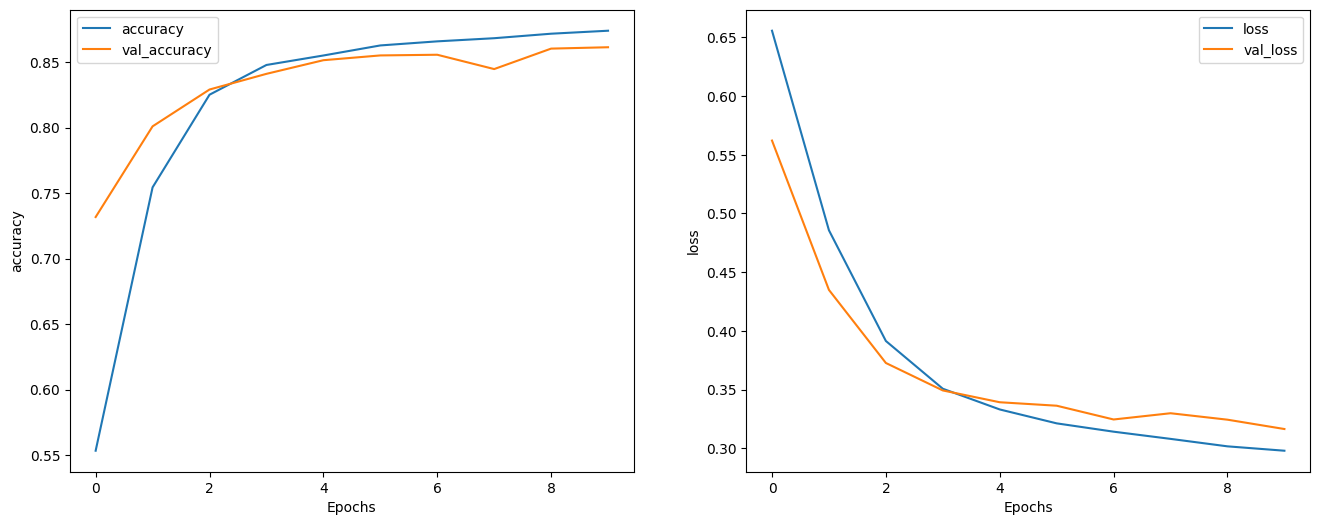

In [20]:
# membuat plot dari akurasi dan loss selama pelatihan model
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')